In [1]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

In [2]:
# -- |Data details| --
participant_id = 2
session = 2
# -- |Data Selection| --
initial_run = 1
n_run = 8

# **Part 0**: Raw Data Overview

In [3]:
# -- |Local parameters|--
epochs_list = [] 

# -- |Event dictionary| --
if session == 1:
    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }
else:
    events_id = { # Set up your event name
        'none': 0,
        'right': 1,
        'left': 2
    }

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250,  #OpenBCI Frequency acquistion
        verbose=False
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(raw_mne, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=False,
        picks = ['C3','Cz','C4','PO7','Pz','PO8']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Not setting metadata
244 matching events found
Applying baseline correction (mode: mean)


Number of events,244
Events,left: 120right: 124
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\89379793.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=2,fmax=36).plot();
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


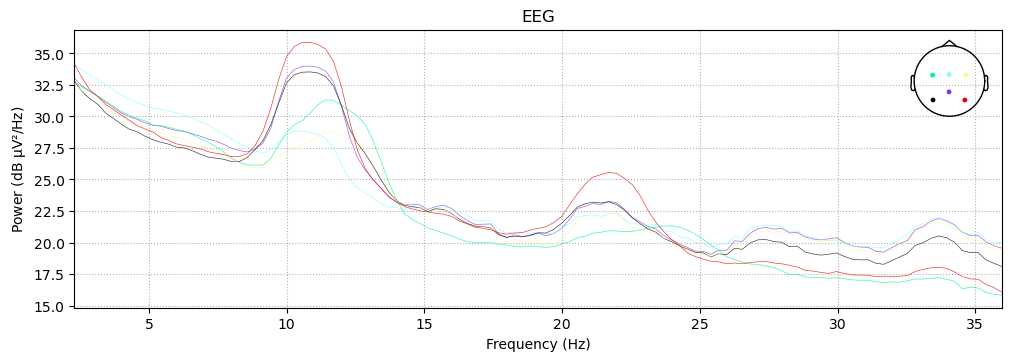

In [4]:
epochs.compute_psd(fmin=2,fmax=36).plot();

# **Part 1**: Left-Right Motor Imagery Classification without Artifact Removal

## Preprocessing

In [5]:
# -- |Local parameters|--
epochs_list = [] 

# -- |Event dictionary| --
if session == 1:
    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }
else:
    events_id = { # Set up your event name
        'none': 0,
        'right': 1,
        'left': 2
    }

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250,  #OpenBCI Frequency acquistion
        verbose=False
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Common Average Reference| --
    mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

    # -- |Bandpass filter| --
    mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(mne_alpha, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=False,
        picks = ['C3','Cz','C4','PO7','Pz','PO8']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Not setting metadata
364 matching events found
Applying baseline correction (mode: mean)


Number of events,364
Events,left: 120none: 124right: 120
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## ERD Visualization

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s finished
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\757762342.py:24: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (2.996 s)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


Applying baseline correction (mode: percent)
Using a threshold of 1.657759
stat_fun(H1): min=-26.127434448503756 max=12.98242800028037
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-26.127434448503756 max=12.98242800028037
Running initial clustering …
Found 27 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.657759
stat_fun(H1): min=-20.917762453235113 max=13.045477829011947
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-20.917762453235113 max=13.045477829011947
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.657759
stat_fun(H1): min=-21.7789529231843 max=12.81878833903566
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-21.7789529231843 max=12.81878833903566
Running initial clustering …
Found 29 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


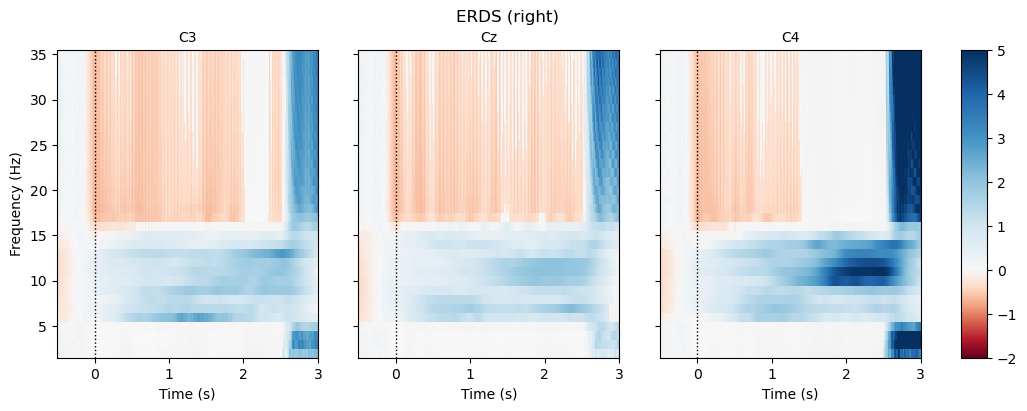

Using a threshold of 1.657759
stat_fun(H1): min=-24.187629958069333 max=14.801999127863263
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-24.187629958069333 max=14.801999127863263
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.657759
stat_fun(H1): min=-27.856997313180997 max=14.104505773340337
Running initial clustering …
Found 27 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-27.856997313180997 max=14.104505773340337
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.657759
stat_fun(H1): min=-19.94732300585725 max=14.6187407964413
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.657759
stat_fun(H1): min=-19.94732300585725 max=14.6187407964413
Running initial clustering …
Found 29 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


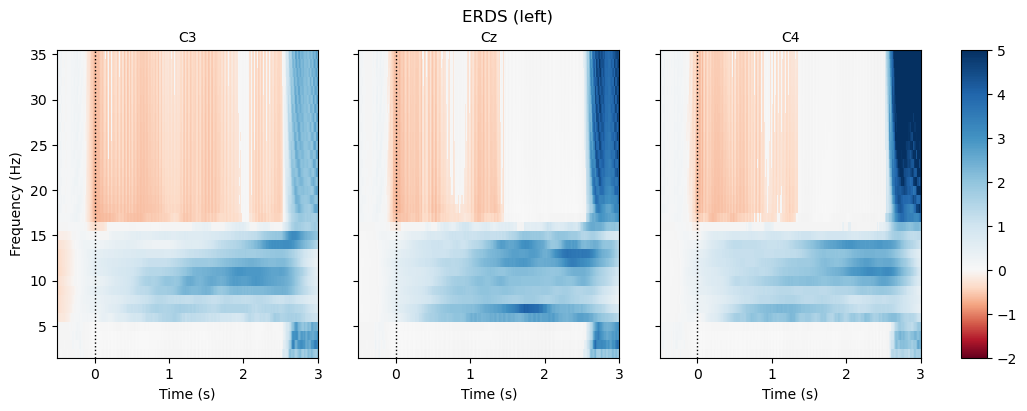

In [6]:
tmin, tmax = -0.5, 3
events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }
freqs = np.arange(2, 36)  # frequencies from 8-12Hz
vmin, vmax = -2, 5  # set min and max ERDS values in plot
baseline = (-0.5, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tfr = epochs.compute_tfr(
    method="multitaper",
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in events_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [7]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4","PO7","Pz","PO8"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 10))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option

## Features Extraction

In [8]:
# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

print(f'EEG data shape: {X.shape}')
print(f'events shape  : {Y.shape}')

EEG data shape: (240, 6, 876)
events shape  : (240,)


Computing rank from data with rank=None
    Using tolerance 3.1e-06 (2.2e-16 eps * 6 dim * 2.4e+09  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.


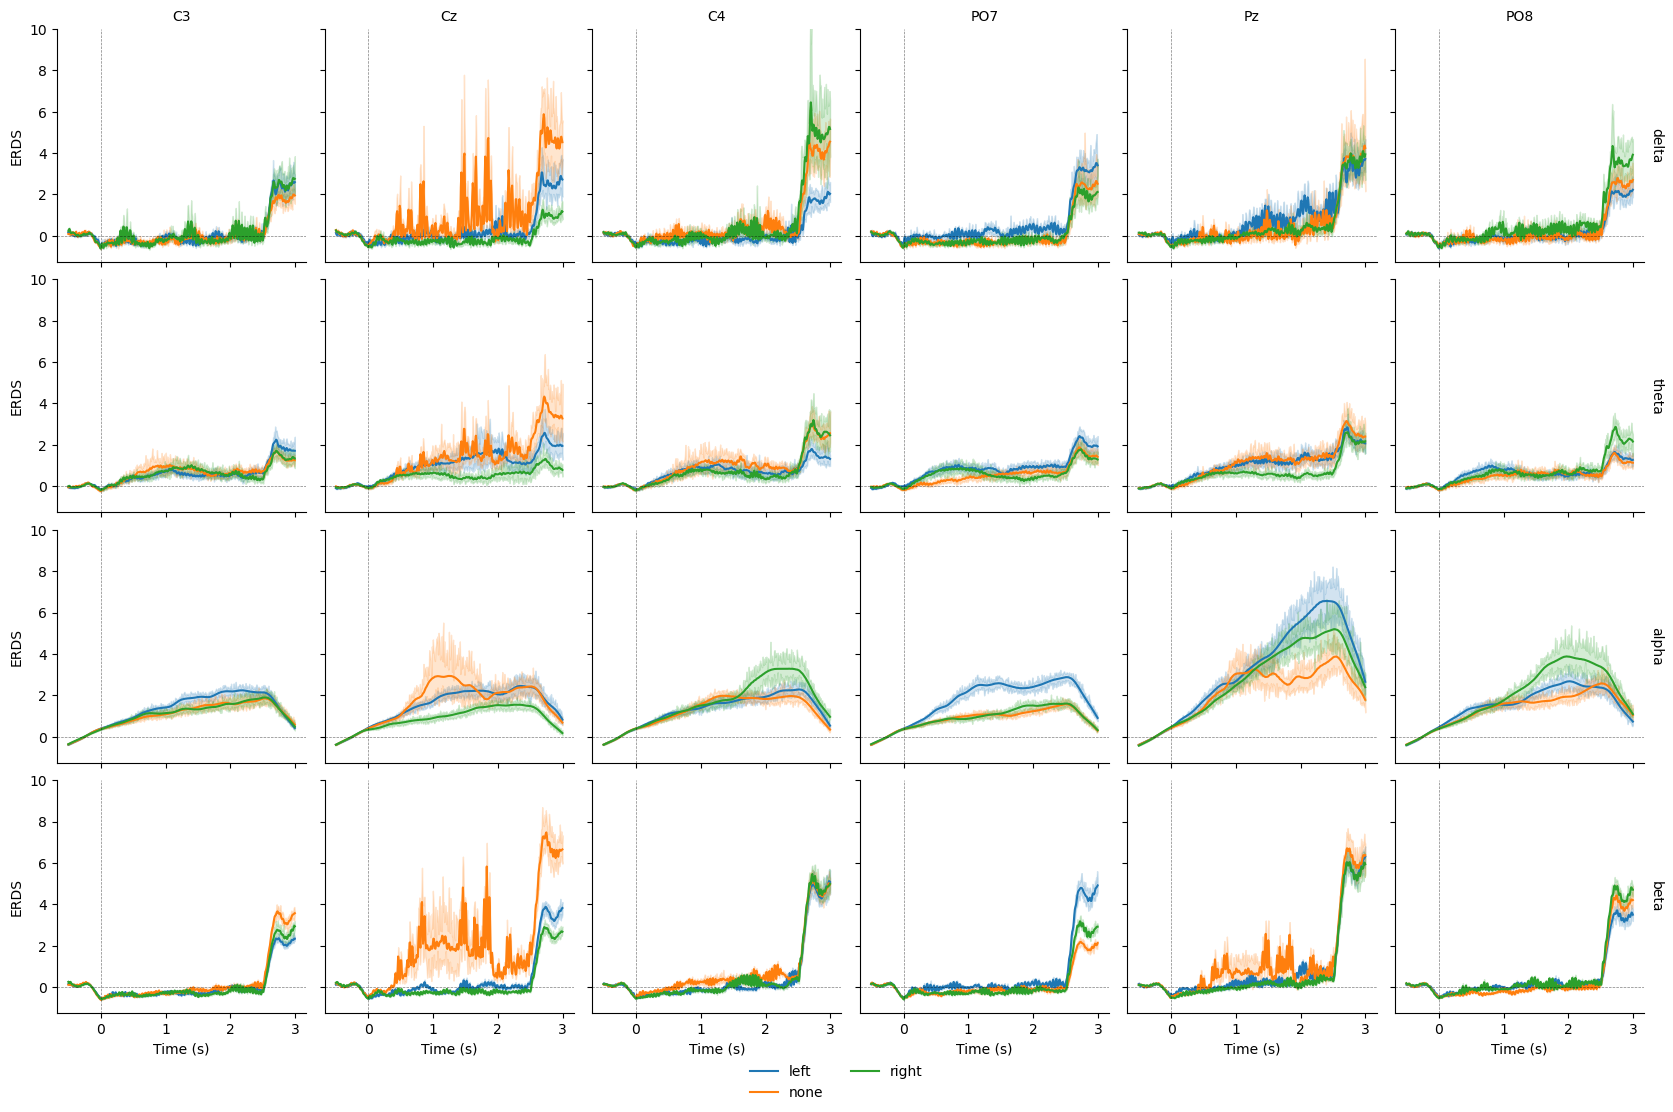

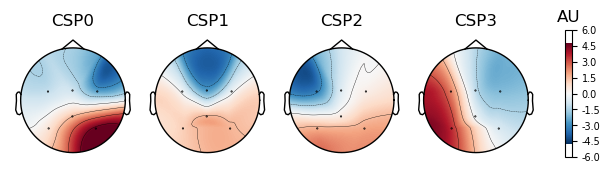

In [9]:
# Initilize CSP
csp = CSP(n_components = 4, norm_trace = False)

# Fit CSP to data 
csp.fit(X,Y)

# Visualize CSP patterns
csp.plot_patterns(epochs.info);

## Classification

In [10]:
# Transform data into CSP space
X_transformed = csp.transform(X)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

Train set shape: (192, 4)
Test set shape : (48, 4)


In [11]:
clf = Pipeline([('SVM', SVC(kernel='linear'))])  
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
accuracy_noArtifactRemoval = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy_noArtifactRemoval}")

report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
print(report)

Accuracy: 0.7708333333333334
              precision    recall  f1-score   support

       right       0.74      0.83      0.78        24
        left       0.81      0.71      0.76        24

    accuracy                           0.77        48
   macro avg       0.78      0.77      0.77        48
weighted avg       0.78      0.77      0.77        48



# **Part 2**: Left-Right Motor Imagery Classification with Artifact Removal

In [12]:
n_iteration = 1000

mne.set_log_level(verbose=False)

K = np.random.rand(4,7)/100    # Initialize hyperparameters

# -- |Channels Information| --
channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250,  #OpenBCI Frequency acquistion
    verbose=False
)

# -- |Event dictionary| --
if session == 1:
    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }
else:
    events_id = { # Set up your event name
        'none': 0,
        'right': 1,
        'left': 2
    }

for j in range(n_iteration):
    accuracy = []
    for k in K: # Generation Iteration
        # -- |Reset Epochs for new hyperparameter| --
        epochs_list = [] 
        for i in range(initial_run,initial_run+n_run):
            # -- |File import| --
            streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder
    
            # -- |EEG data| --
            EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data

            raw_data = ((EEG["time_series"].T)/1000000)[:-1,:] # Convert microvoltage to voltage
            EOG = ((EEG["time_series"].T)/1000000)[-1,:]

            # -- |Events|--
            Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

            event_index = Events["time_series"].T[0] #Get all event marker of experiment 
            event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

            events = np.column_stack((np.array(event_timestamp, dtype = int),
                                np.zeros(len(event_timestamp), dtype = int),
                                np.array(event_index, dtype = int)))

            # -- |Artifact Removal| --
            raw_data -= np.diag(k)@np.tile(EOG,(7,1))

            # -- |Create MNE rawarray| --
            raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

            # -- |Common Average Reference| --
            mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

            # -- |Bandpass filter| --
            mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

            # -- |Epoch Segmentation| --
            epochs = mne.Epochs(mne_alpha, events, 
                tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
                tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
                event_id =events_id,
                preload = True,
                verbose=False,
                picks = ['C3','Cz','C4','PO7','Pz','PO8']
            )

            epochs_list.append(epochs)

        # -- |Epoch Settings| --
        epochs = mne.concatenate_epochs(epochs_list)
        epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

        # -- |Get EEG data and events| --
        X = epochs[['right','left']].get_data(copy=False)
        Y = epochs[['right','left']].events[:, -1]

        # -- |Initilize CSP| --
        csp = CSP(n_components = 4, norm_trace = False)

        # -- |Fit CSP to data| --
        csp.fit(X,Y)

        # -- |Transform data into CSP space| --
        X_transformed = csp.transform(X)

        # -- |Split data into training and test sets| --
        X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

        # -- |Classification| --
        clf = Pipeline([('SVM', SVC(kernel='linear'))])  
        clf.fit(X_train, Y_train)

        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(Y_test, y_pred))
    
    # -- |Genetic Algorithm| --
    # Parent selection
    parents_ind = np.argpartition(accuracy,-2)[-2:] # select top 2 offspring as new parents
    parents = K[parents_ind]

    offsprings = []
    for offs in range(2):
        offspring = []
        # Breeding
        for m in range(7):
            if np.random.rand() >= 0.5:
                offspring.append(parents[0][m])
            else:
                offspring.append(parents[1][m])
            
        # Mutation
        if np.random.rand() >= 1/(len(parents[0])):
            offspring[np.random.randint(0,len(parents[0]))] += (2*np.random.rand() - 1)/100
        
        offsprings.append(offspring)
    K = np.concatenate((parents, offsprings))

print(K,'\n')
print(f'Accuracy without artifact removal: {accuracy_noArtifactRemoval}')
print(f'Overall accuracy:\n{accuracy}')
print(f'Output hyperparameters {K[np.argmax(accuracy)]} achieved {np.max(accuracy)} accuracy.')

[[-0.00385097  0.07813093  0.01901113  0.00731633 -0.00529262 -0.04394503
   0.10806862]
 [-0.00544744  0.08647508  0.01901113  0.00731633 -0.00529262 -0.04033866
   0.10806862]
 [-0.00544744  0.07813093  0.01901113  0.00731633 -0.00529262 -0.04033866
   0.10806862]
 [-0.00385097  0.09114412  0.01901113  0.00731633 -0.00529262 -0.04394503
   0.10806862]] 

Accuracy without artifact removal: 0.7708333333333334
Overall accuracy:
[0.7708333333333334, 0.7708333333333334, 0.7708333333333334, 0.7708333333333334]
Output hyperparameters [-0.00385097  0.07813093  0.01901113  0.00731633 -0.00529262 -0.04394503
  0.10806862] achieved 0.7708333333333334 accuracy.


# Other Visualizations

In [13]:
right_MI = epochs['right'].average() # Average all right trials
right_MI

Condition,right
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,120
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [14]:
left_MI = epochs['left'].average() # Average all left trials
left_MI

Condition,left
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,120
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [15]:
right_electrodes = ['C4','PO8']
left_electrodes = ['C3','PO7']
center_electrodes = ['Cz']

right_MI_R = epochs['right'].average(picks = right_electrodes)
right_MI_L = epochs['right'].average(picks = left_electrodes)
left_MI_R = epochs['left'].average(picks = right_electrodes)
left_MI_L = epochs['left'].average(picks = left_electrodes)

## Time Domain

### Time Series Plot

#### Right Motor Imagery

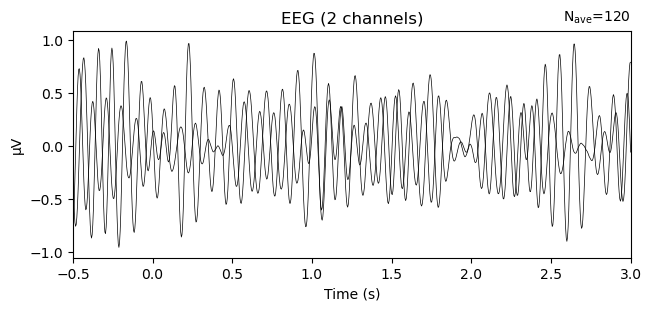

In [16]:
right_MI.plot(picks = right_electrodes, spatial_colors=False);

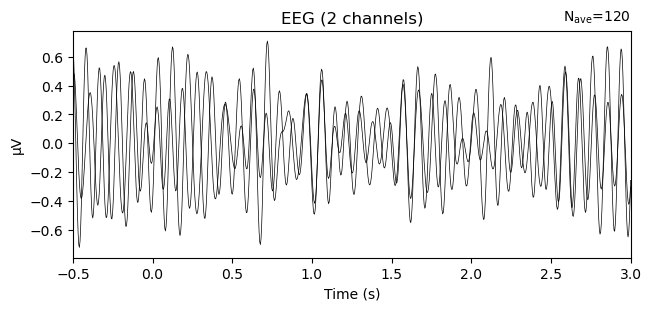

In [17]:
right_MI.plot(picks = left_electrodes, spatial_colors=False);

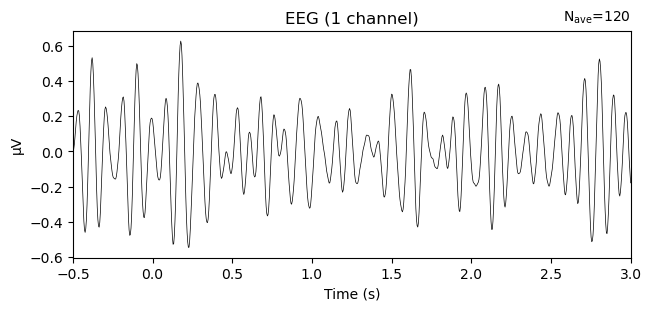

In [18]:
right_MI.plot(picks = center_electrodes, spatial_colors=False);

#### Left Motor Imagery

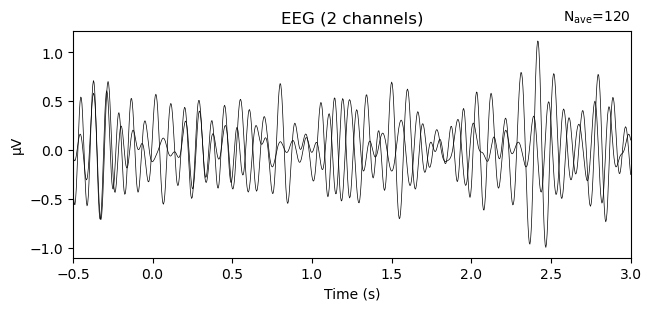

In [19]:
left_MI.plot(picks = right_electrodes, spatial_colors=False);

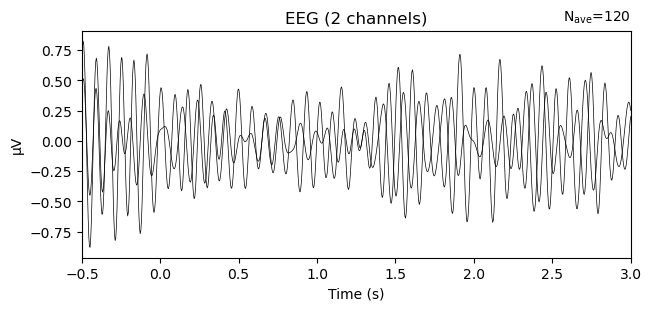

In [20]:
left_MI.plot(picks = left_electrodes, spatial_colors=False);

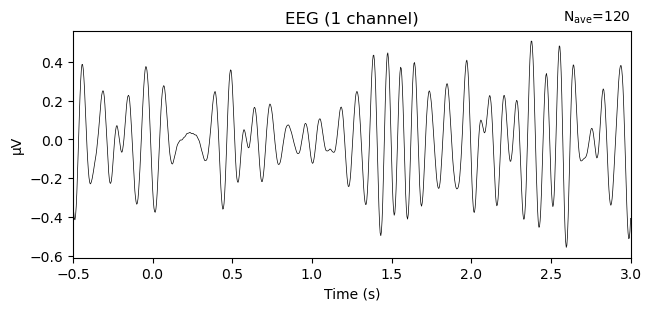

In [21]:
left_MI.plot(picks = center_electrodes, spatial_colors=False);

### Temporal Topology Map

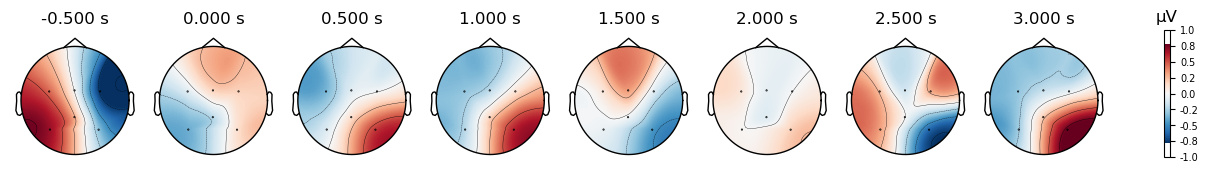

In [22]:
right_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

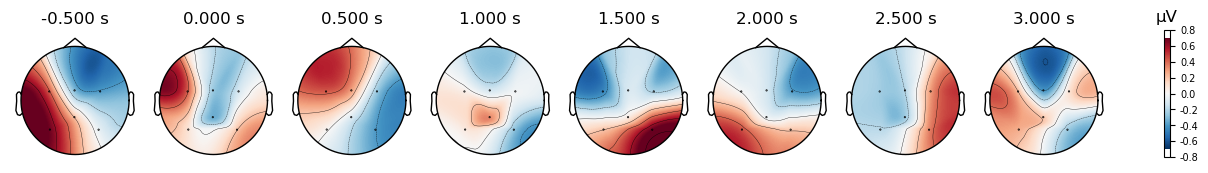

In [23]:
left_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Jointed Plot

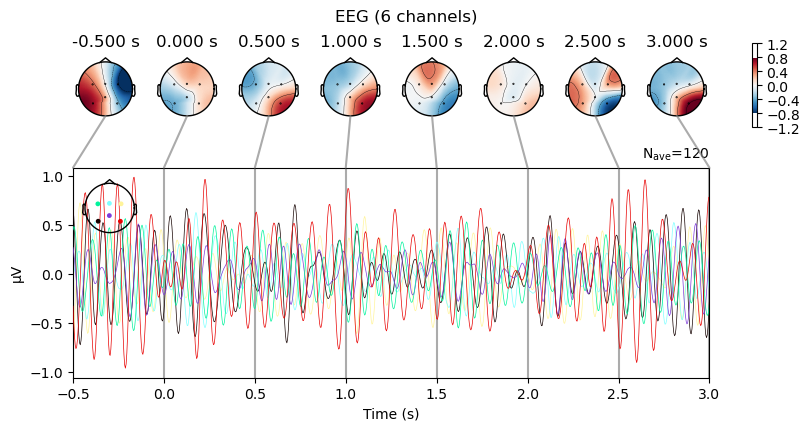

In [24]:
right_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

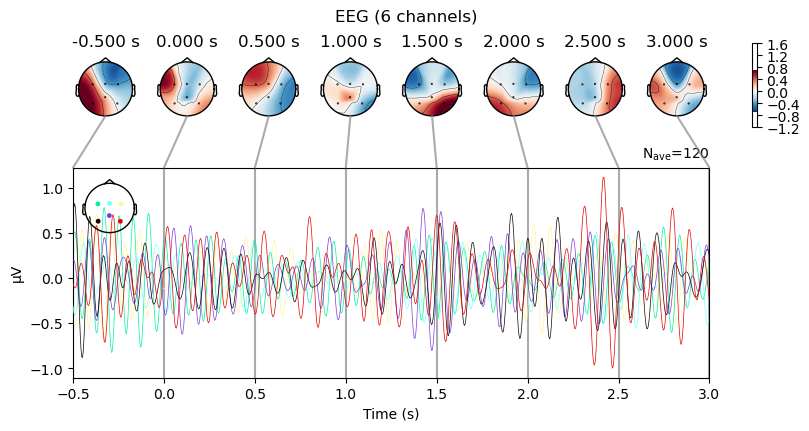

In [25]:
left_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Difference Plot

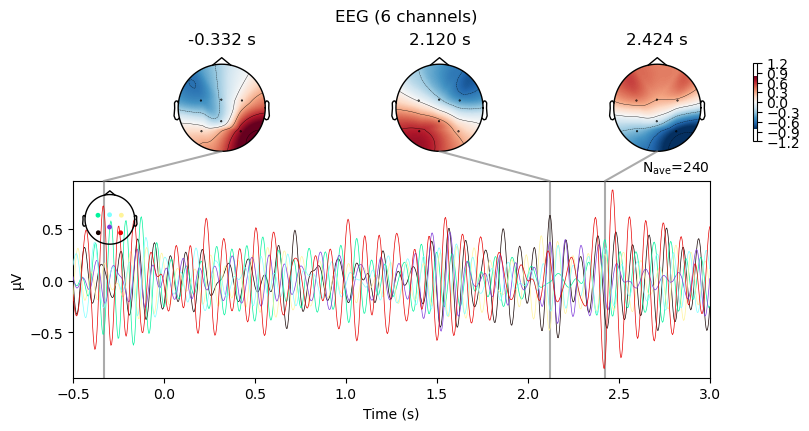

In [26]:
MI_diff = mne.combine_evoked((right_MI,-left_MI), weights='equal')
MI_diff.plot_joint();

## Time-frequency Domain

In [27]:
epochs.compute_psd(fmin = 2, fmax = 60).plot();

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\787761887.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin = 2, fmax = 60).plot();
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


# Temporary Section

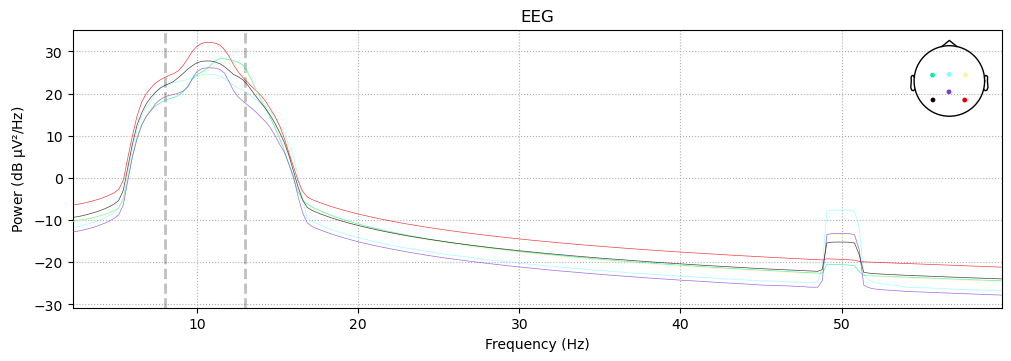

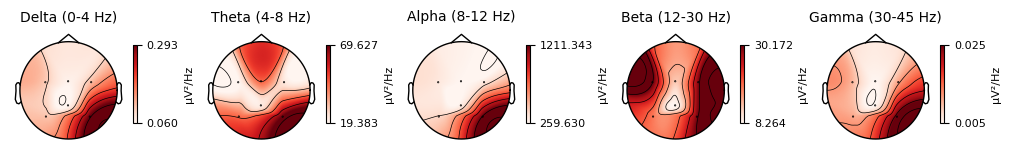

In [28]:
epochs['right'].compute_psd().plot_topomap();

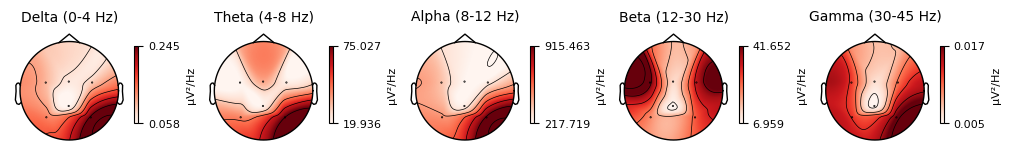

In [29]:
epochs['left'].compute_psd().plot_topomap();

In [30]:
import numpy as np
import scipy


class CSP_ORI:
    def __init__(self, n_components=4):
        self.n_components = n_components

    def fit(self, x, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        if n_classes != 2:
            raise ValueError("n_classes must be 2.")

        covs = []
        for this_class in self.classes:
            x_class = x[y == this_class]
            # Convert data dimention to (channels, epoch * data_point)
            _, n_channels, _ = x_class.shape
            x_class = np.transpose(x_class, [1, 0, 2])
            x_class = x_class.reshape(n_channels, -1)
            cov = np.dot(x_class, x_class.T)
            covs.append(cov)

        # Solve generalized eigenvalue problem
        eig_vals, eig_vecs = scipy.linalg.eigh(covs[0],covs[1])
        for i in range(len(eig_vecs)):
            eig_vecs[i] = eig_vecs[i] / np.linalg.norm(eig_vecs[i])

        i = np.argsort(eig_vals)
        ix = np.empty_like(i)
        ix[1::2] = i[: len(i) // 2]
        ix[0::2] = i[len(i) // 2 :][::-1]

        eig_vecs = eig_vecs[:, ix]
        self.filters = eig_vecs.T
        self.patterns = np.linalg.inv(eig_vecs)
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        self.mean = x.mean(axis=0)
        self.std = x.std(axis=0)

    def transform(self, x):
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        x -= self.mean
        x /= self.std

        return x

    def fit_transform(self, x, y):
        self.fit(x, y)

        return self.transform(x)

In [31]:
csp = CSP_ORI()
csp.fit(X,Y)

In [32]:
def cov(x_class):
    _, n_channels, _ = x_class.shape
    x_class = np.transpose(x_class, [1, 0, 2])
    x_class = x_class.reshape(n_channels, -1) # Concat all trials
    return np.dot(x_class, x_class.T)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [33]:
df = epochs.to_data_frame()
df

,time,condition,epoch,C3,Cz,C4,PO7,Pz,PO8
0,-0.500,right,0,-0.751292,-1.462928,1.346424,1.429630,-0.890969,1.149764
1,-0.496,right,0,-0.797201,-1.596729,1.048661,1.842095,-0.942841,1.249257
2,-0.492,right,0,-0.846548,-1.665235,0.697668,2.121074,-0.881575,1.294612
3,-0.488,right,0,-0.922868,-1.593636,0.316412,2.190469,-0.756602,1.271848
4,-0.484,right,0,-1.046706,-1.296604,-0.077123,1.988287,-0.626856,1.174827
...,...,...,...,...,...,...,...,...,...
318859,2.984,right,365,-3.175738,2.252310,3.570577,-4.490701,0.775890,-0.655532
318860,2.988,right,365,-3.227285,2.474262,4.268160,-5.999477,-0.085992,0.485385
318861,2.992,right,365,-2.987909,2.511045,4.559495,-7.059590,-1.024623,1.671402
318862,2.996,right,365,-2.486350,2.313029,4.443998,-7.563630,-1.935368,2.808668


In [34]:
df.describe()

,time,epoch,C3,Cz,C4,PO7,Pz,PO8
count,318864.000000,318864.000000,318864.000000,318864.000000,318864.000000,318864.000000,318864.000000,318864.000000
mean,1.250000,182.500000,-0.009022,-0.009001,-0.010043,0.010763,0.007584,0.022461
std,1.011519,105.453334,2.926022,2.312372,2.725676,2.983919,2.224110,4.371941
min,-0.500000,0.000000,-13.845308,-32.855691,-16.419187,-15.375964,-16.157334,-25.071734
25%,0.375000,91.750000,-1.871604,-1.308362,-1.712874,-1.913185,-1.221803,-2.661799
50%,1.250000,182.500000,-0.010270,-0.006862,-0.005198,0.015033,0.010408,0.026686
75%,2.125000,273.250000,1.857175,1.287684,1.701776,1.928916,1.240740,2.705642
max,3.000000,365.000000,13.937292,35.515678,13.965104,17.494927,19.101485,23.972912


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\744519546.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\744519546.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


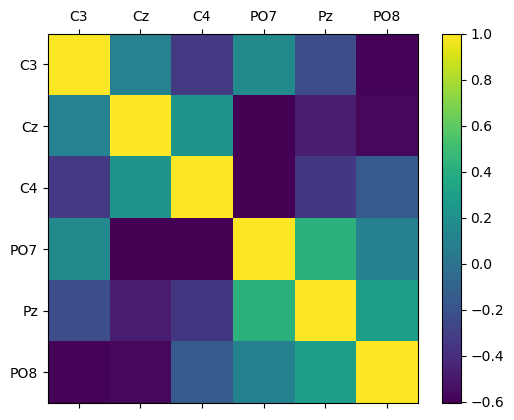

In [35]:
df_numerical = df[epochs.info['ch_names']]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [36]:
x_right = X[Y==0]
np.linalg.eigvals(cov(x_right))

array([0., 0., 0., 0., 0., 0.])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\2090067297.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\2090067297.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


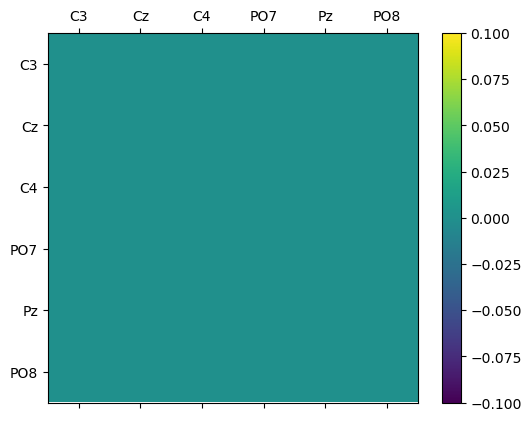

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_right), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [38]:
x_left = X[Y==1]
np.linalg.eigvals(cov(x_left))

array([3.13281048e-06, 1.65067992e-06, 4.54855839e-08, 2.79425847e-07,
       5.66666438e-07, 4.48525503e-07])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\1886860997.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42940\1886860997.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


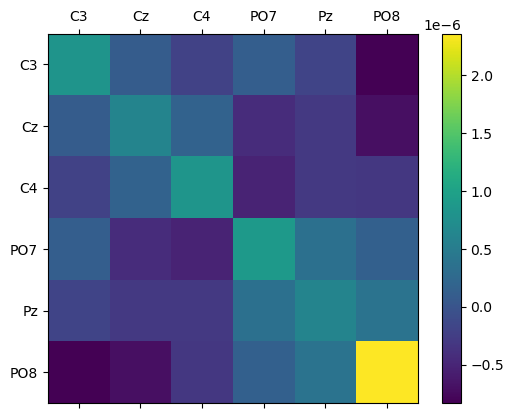

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_left), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()